<a href="https://colab.research.google.com/github/gkianfar/TIHM-Dataset-Visualization/blob/main/tihm_featureExtraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Clone Github repo and set working directory path**

In [1]:
!git clone https://github.com/gkianfar/TIHM-Dataset-Visualization

Cloning into 'TIHM-Dataset-Visualization'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 150 (delta 2), reused 0 (delta 0), pack-reused 144 (from 1)
Receiving objects: 100% (150/150), 19.87 MiB | 13.24 MiB/s, done.
Resolving deltas: 100% (76/76), done.


**Load packages**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
from matplotlib import cm
import matplotlib.patches as mpatches
from collections.abc import Iterable
from sklearn.preprocessing import StandardScaler
import os
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
## Set colour palette
ibm_colorblind = ['#648FFF', '#FE6100', '#DC267F', '#785EF0', '#FFB000','#48A9A6']
sns.set_palette(ibm_colorblind)

**Functions**

In [3]:
def correct_col_type(df,col):
    raw_type = str(type(df[col].dtype)).split('.')[-1].split('\'')[0].lower()
    #print(col,raw_type)
    if 'object' in raw_type:
        if 'date' in col or 'timestamp' in col or 'datetime' in col:
            return pd.to_datetime(df[col])
        else:
            return df[col].astype('category')
    else:
        return df[col]


def gen_date_col(df, tcol):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df[tcol].dt.date
    return df





**Set Data and Fig folders paths**

In [4]:
## Please change the path with the path of your dataset
%cd /content/TIHM-Dataset-Visualization
DPATH = './Data'
SAVE_PATH = './Figs/'
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)



/content/TIHM-Dataset-Visualization


**Import Files**

In [5]:
### Labels
f = 'Labels.csv'
fpth = os.path.join(DPATH,f)
labels_df = pd.read_csv(fpth)
for col in labels_df.columns:
    labels_df[col] = correct_col_type(labels_df,col)
if 'date' in labels_df.columns:
    labels_df = labels_df.rename(columns={'date':'timestamp'})
    labels_df['timestamp'] = pd.to_datetime(labels_df['timestamp'])
    labels_df['date'] = labels_df['timestamp'].dt.date
    labels_df['time'] = labels_df['timestamp'].dt.time

if 'type' in labels_df.columns:
    labels_df = labels_df.rename(columns={'type':'label'})

In [6]:
### Activity

f = 'Activity.csv'
fpth = os.path.join(DPATH,f)
df = pd.read_csv(fpth)
for col in df.columns:
    df[col] = correct_col_type(df,col)
if 'date' in df.columns:
    activity_df = df.rename(columns={'date':'timestamp'})
    activity_df['timestamp'] = pd.to_datetime(activity_df['timestamp'])
    activity_df['date'] = activity_df['timestamp'].dt.date
    activity_df['time'] = activity_df['timestamp'].dt.time


activity_patients = np.unique(activity_df['patient_id'])

In [7]:
### Physiology
f = 'Physiology.csv'
fpth = os.path.join(DPATH,f)
df = pd.read_csv(fpth)
for col in df.columns:
    df[col] = correct_col_type(df,col)
if 'date' in df.columns:
    physiology_df = df.rename(columns={'date':'timestamp'})
    physiology_df['timestamp'] = pd.to_datetime(physiology_df['timestamp'])
    physiology_df['date'] = physiology_df['timestamp'].dt.date
    physiology_df['time'] = physiology_df['timestamp'].dt.time

#physiology_df = gen_date_col(df,tcol='timestamp')

physiology_patients = np.unique(physiology_df['patient_id'])
physiology_parameters = np.unique(df['device_type'])

In [8]:
# Sleep
f = 'Sleep.csv'
fpth = os.path.join(DPATH,f)
df = pd.read_csv(fpth)
for col in df.columns:
    df[col] = correct_col_type(df,col)
if 'date' in df.columns:
    sleep_df = df.rename(columns={'date':'timestamp'})
    sleep_df['timestamp'] = pd.to_datetime(sleep_df['timestamp'])
    sleep_df['date'] = sleep_df['timestamp'].dt.date
    sleep_df['time'] = sleep_df['timestamp'].dt.time

#physiology_df = gen_date_col(df,tcol='timestamp')

sleep_patients = np.unique(sleep_df['patient_id'])

In [9]:
f = 'Demographics.csv'
fpth = os.path.join(DPATH,f)
demographics_df = pd.read_csv(fpth)
for col in demographics_df.columns:
    demographics_df[col] = correct_col_type(demographics_df,col)

Data Cleaning

In [10]:
activity_df = activity_df.drop_duplicates()
physiology_df = physiology_df.drop_duplicates()
sleep_df = sleep_df.drop_duplicates()

# Activity data noise removal
# Activities by a specific patient occured simultaneously

# Removing simultaneous activities by a patient
keep = 'first' # last, none
if keep == 'none':
  keep = False

activity_df = activity_df.drop_duplicates(subset=['patient_id', 'timestamp'], keep=keep).copy()

In [ ]:
# Simultaneous activity and sleep
merge_activity_sleep = pd.merge(cleaned_activity, sleep_df, how='outer')

merge_activity_sleep = pd.merge(cleaned_activity, sleep_df, how='outer')
merge_activity_sleep = merge_activity_sleep[(~merge_activity_sleep['state'].isna()) & (~merge_activity_sleep['location_name'].isna())]
sleep_patients = merge_activity_sleep['patient_id'].unique()
sleep_activity_mismatch = {}
for pid in sleep_patients:
  print(merge_activity_sleep[(merge_activity_sleep['patient_id']==pid) & (merge_activity_sleep['location_name']!='Bedroom')])


Data Combining

In [15]:
seed = 2025  # Set your desired seed value

# Set seed for Python's and Numpy's random modules
random.seed(seed)
np.random.seed(seed)

# Set the number of negative samples per positive sample
negative_sample_size = 1

# Missing data filling approach for physiology data (Currently, just filling
# with average value on all normal days is considered)
if_fill_physiology = True
fill_type = 'average_all_normal_days'

# Observation backward time-window for activities
interval = 6 # backward Time Window

# True if all past and future normal samples are consideredfor degree calculation,
# otherwise it considers only past
non_agit_observe_all = False


# Average physiology parameters in general in case a patient don't have these measurements at all
avg_params = {
    'Body Temperature':36.0,
    'Body weight':70.0,
    'Diastolic blood pressure':80.0,
    'Heart rate':90.0,
    'O/E - muscle mass':40.0,
    'Skin Temperature':35.0,
    'Systolic blood pressure':160.0,
    'Total body water':50.0
}

#  Filter agitation samples to discover the patients with agitation
agitation_df = labels_df[labels_df['label']=='Agitation'].copy()
agitation_patientID = agitation_df['patient_id'].tolist()

# Set observation window duration for activities and determine start time of observation window for each agitation sample
agitation_endTime = agitation_df['timestamp'].tolist()
agitation_startTime = pd.to_datetime(agitation_endTime) - pd.Timedelta(hours=interval)
agitation_startTime = agitation_startTime.tolist()

# Find the number of agitation samples associated with each patient in agitation dataframe
agitation_patients = np.unique(agitation_df['patient_id'])
each_patient_agitation_sample = agitation_df['patient_id'].value_counts()

# Store the dates for available agitation label, activity, and physiological measurements per patient
agitation_days = {}
activity_days = {}
physiology_days = {}

# Loop through the datasets to collect required data
for id in agitation_patients:
   agitation_days[id] = agitation_df['date'][agitation_df['patient_id'] == id].unique()
   activity_days[id] = activity_df['date'][activity_df['patient_id'] == id].unique()
   physiology_days[id] = physiology_df['date'][physiology_df['patient_id'] == id].unique()


agitation_dataset = []
non_agitation_dataset = []

# Iterate through each patient_id, start_time, and end_time
for index, (patient_id, start_time, end_time) in enumerate(zip(agitation_patientID, agitation_startTime, agitation_endTime)):

    ## demographics data
    patient_age = demographics_df[demographics_df['patient_id']==patient_id]['age'].values[0]
    patient_sex = demographics_df[demographics_df['patient_id']==patient_id]['sex'].values[0]

    patient_agit_days = agitation_days[patient_id]
    patient_activity_days = activity_days[patient_id]
    patient_non_agit_days = np.array([date for date in patient_activity_days if date not in patient_agit_days])
    patient_physiology_days = physiology_days[patient_id]
    patient_non_agit_physio_days = [date for date in patient_non_agit_days if date in patient_physiology_days]


    print(f'{index}-user: {patient_id} - from {start_time} to {end_time}')

    # Filter the DataFrame for the current patient and time range
    filtered_df = activity_df[(activity_df['patient_id'] == patient_id) &
                            (activity_df['timestamp'] >= start_time) &
                            (activity_df['timestamp'] <= end_time)]

    # Store the results in the list
    agit_activity = filtered_df['location_name'].tolist()


    if non_agit_observe_all:
      patient_observed_non_agit_days = patient_non_agit_days.copy()
    else:
      patient_observed_non_agit_days = patient_non_agit_days[patient_non_agit_days<day]

    agit_weekday = pd.Timestamp(end_time).day_name()

    # separate the corresponding non agitation intervals from normal days of each patient
    observed_non_agit_activity = []
    for d in patient_observed_non_agit_days:
      if start_time.time() < end_time.time():
        filtered_df = activity_df[(activity_df['patient_id'] == patient_id) &
                                  (activity_df['date'] == d) &
                                  (activity_df['time'] >= start_time.time()) &
                                  (activity_df['time'] <= end_time.time())]
      else:
        raise Exception("Start time is after end time")


      observed_non_agit_activity.append(filtered_df['location_name'].tolist())
    print(f' observed size: {len(observed_non_agit_activity)}')
    if len(observed_non_agit_activity)==0:
        #raise Exception('No observation')
        observed_non_agit_activity.append(agit_activity)

    ### physiology parameters
    agit_params = []
    agit_physio_df = physiology_df[(physiology_df['patient_id']==patient_id) & (physiology_df['date']==end_time.date())]
    agit_unique_params = agit_physio_df['device_type'].unique().tolist()

    ### for agitation samples
    for param in physiology_parameters:
        if (param in agit_unique_params):
            agit_params.append((param,agit_physio_df['value'][agit_physio_df['device_type'] == param].mean()))
            print('value exists')

        else:
            print('no value')
            if if_fill_physiology:

              if fill_type == 'average_all_normal_days':

                selected_physio_to_fill = physiology_df['value'][(physiology_df['patient_id']==patient_id) &
                  (physiology_df['device_type'] == param) & (physiology_df['date'].isin(patient_non_agit_physio_days))].tolist()

                value = avg_params[param] if not selected_physio_to_fill else np.mean(selected_physio_to_fill)
              else:
                raise Exception("Fill type not supported")

            else:
              print('Filled with NaN')
              value = np.NaN

            agit_params.append((param,value))


    # Append the collected data to agitation_dataset (positive samples)
    agitation_dataset.append([patient_id, start_time, end_time, agit_activity, observed_non_agit_activity, agit_params, patient_age, patient_sex, agit_weekday])

    if len(patient_non_agit_days) > 0:
        sampled_non_agit_days = np.random.choice(patient_non_agit_days, size=min(negative_sample_size, len(patient_non_agit_days)), replace=False)
    else:
        sampled_non_agit_days = []

    for day in sampled_non_agit_days:

      # The same time start and end but in a different day
      start_time_non_agit = pd.Timestamp.combine(day, start_time.time())
      end_time_non_agit = pd.Timestamp.combine(day, end_time.time())

      print(f'\t non-agit: {patient_id} - from {start_time_non_agit} to {end_time_non_agit}')

      if start_time.time() < end_time.time():
        filtered_df = activity_df[(activity_df['patient_id'] == patient_id) &
                                  (activity_df['date'] == day) &
                                  (activity_df['time'] >= start_time.time()) &
                                  (activity_df['time'] <= end_time.time())]
      else:
        raise Exception("Start time is after end time")

      # Store the results in the list
      non_agit_activity = filtered_df['location_name'].tolist()
      if non_agit_observe_all:
        patient_observed_non_agit_days = patient_non_agit_days.copy()
      else:
        patient_observed_non_agit_days = patient_non_agit_days[patient_non_agit_days<day]

      non_agit_weekday = pd.Timestamp(end_time_non_agit).day_name()

      # separate the corresponding non agitation intervals from normal days of each patient
      observed_non_agit_activity = []
      for d in patient_observed_non_agit_days:
        if start_time.time() < end_time.time():
          filtered_df = activity_df[(activity_df['patient_id'] == patient_id) &
                                    (activity_df['date'] == d) &
                                    (activity_df['time'] >= start_time.time()) &
                                    (activity_df['time'] <= end_time.time())]
        else:
          raise Exception("Start time is after end time")


        observed_non_agit_activity.append(filtered_df['location_name'].tolist())
      print(f' observed size: {len(observed_non_agit_activity)}')
      if len(observed_non_agit_activity)==0:
        #raise Exception('No observation')
        observed_non_agit_activity.append(non_agit_activity)

      non_agit_params = []
      non_agit_physio_df = physiology_df[(physiology_df['patient_id']==patient_id) & (physiology_df['date']==day)]
      non_agit_unique_params = non_agit_physio_df['device_type'].unique().tolist()

      for param in physiology_parameters:
          if (param in non_agit_unique_params):
              non_agit_params.append((param,non_agit_physio_df['value'][non_agit_physio_df['device_type'] == param].mean()))
              print('value exists')
          else:
              print('No value')
              if if_fill_physiology:

                if fill_type == 'average_all_normal_days':

                  selected_physio_to_fill = physiology_df['value'][(physiology_df['patient_id']==patient_id) &
                    (physiology_df['device_type'] == param) & (physiology_df['date'].isin(patient_non_agit_physio_days))].tolist()

                  value = avg_params[param] if not selected_physio_to_fill else np.mean(selected_physio_to_fill)
                else:
                  raise Exception("Fill type not supported")

              else:
                print('Filled with NaN')
                value = np.NaN

              non_agit_params.append((param,value))

      # Append to non_agitation_dataset. (Note: Instead of considering start_time_non_agit
      # and end_time_non_agit, we consider start_time and end_time to facilitate negative sampling in later stages
      non_agitation_dataset.append([patient_id, start_time, end_time, non_agit_activity, observed_non_agit_activity, non_agit_params, patient_age, patient_sex, non_agit_weekday])





0-user: 16f4b - from 2019-04-11 06:00:22 to 2019-04-11 12:00:22
 observed size: 32
no value
no value
no value
no value
no value
no value
no value
no value
	 non-agit: 16f4b - from 2019-04-29 06:00:22 to 2019-04-29 12:00:22
 observed size: 20
value exists
No value
value exists
value exists
No value
value exists
value exists
No value
1-user: 16f4b - from 2019-04-14 06:00:07 to 2019-04-14 12:00:07
 observed size: 20
no value
no value
no value
no value
no value
no value
no value
no value
	 non-agit: 16f4b - from 2019-06-02 06:00:07 to 2019-06-02 12:00:07
 observed size: 50
No value
No value
No value
No value
No value
No value
No value
No value
2-user: 16f4b - from 2019-04-15 12:00:24 to 2019-04-15 18:00:24
 observed size: 50
no value
no value
no value
no value
no value
no value
no value
no value
	 non-agit: 16f4b - from 2019-06-14 12:00:24 to 2019-06-14 18:00:24
 observed size: 62
No value
No value
No value
No value
No value
No value
No value
No value
3-user: 16f4b - from 2019-04-16 12:00:

In [ ]:
import pickle
pickle.dump(agitation_dataset,open('/content/drive/MyDrive/datasets/agitation_dataset.pkl','wb'))
pickle.dump(non_agitation_dataset,open('/content/drive/MyDrive/datasets/non_agitation_dataset.pkl','wb'))

In [55]:
class AGITATION_DATASET():
  def __init__(self,dataset, location_names, physiology_names):
    num_samples = len(dataset)
    self.patient_id = [dataset[i][0] for i in range(num_samples) ]
    self.start_time = [dataset[i][1] for i in range(num_samples) ]
    self.end_time = [dataset[i][2] for i in range(num_samples) ]
    self.activity = [dataset[i][3] for i in range(num_samples) ]
    self.non_agitation = [dataset[i][4] for i in range(num_samples) ]
    self.agitation_params = [dataset[i][5] for i in range(num_samples) ]
    self.age = [dataset[i][6] for i in range(num_samples) ]
    self.gender = [dataset[i][7] for i in range(num_samples) ]
    self.week_day = [dataset[i][8] for i in range(num_samples) ]

    # Initiate the dataframe with basic informations
    self.init_df()
    self.location_names = location_names
    self.location_columns = []
    self.location_columns.extend(self.location_names)
    relative_cols = []
    mean_cols = []
    std_cols = []
    for location in self.location_names:
      relative_cols.append(location+'_count_relative')
      mean_cols.append('normal_'+location+'_count_mean')
      std_cols.append('normal_'+location+'_count_std')
    self.location_columns.extend(relative_cols)
    self.location_columns.extend(mean_cols)
    self.location_columns.extend(std_cols)
    self.physiology_names = physiology_names
  def __len__(self):
    return len(self.patient_id)
  def init_df(self):
    self.feature_df = pd.DataFrame(np.column_stack((self.patient_id,
                      self.start_time, self.end_time, self.week_day, self.age, self.gender)),
                       columns=['patient_id', 'start_time', 'end_time', 'week_day','age', 'gender'])
  def activity_change(self, inplace = True):
    activity_change = []
    for index in range(self.__len__()):
      dummy = self.activity[index]
      dummy = np.array(dummy)
      result = np.concatenate([[np.NaN], dummy[1:] != dummy[:-1]])
      changed = np.nansum(result)

      normal_activity_changes = []
      for arr in self.non_agitation[index]:
        arr = np.array(arr)
        result = np.concatenate([[np.NaN], arr[1:] != arr[:-1]])
        normal_activity_changes.append(np.nansum(result))

      # Calculate sample mean and standard deviation
      normal_activity_change_mean = np.mean(normal_activity_changes)
      normal_activity_change_std = np.std(normal_activity_changes)
      relative_change = (changed - normal_activity_change_mean)/normal_activity_change_std
      if normal_activity_change_std==0:
        relative_change = 0
      activity_change.append([changed, relative_change, normal_activity_change_mean, normal_activity_change_std])
      activity_change_df = pd.DataFrame(activity_change, columns=['change_count', 'change_relative', 'normal_change_mean','normal_change_std'])
    if inplace:
      self.feature_df = pd.concat([self.feature_df,activity_change_df],axis=1)
    else:
      return activity_change_df
  def activity_count(self, inplace = True):
    activity_count = []
    for index in range(self.__len__()):
      dummy = self.activity[index]
      dummy = np.array(dummy)
      count_df = pd.Series(dummy).value_counts()
      #print(count_df)
      result = []
      for location in self.location_names:
        if location in count_df.index:
          result.append(count_df.loc[location])
        else:
          result.append(0)


      normal_activity_counts = []
      for arr in self.non_agitation[index]:
        arr = np.array(arr)
        count_df = pd.Series(arr).value_counts()
        result = []
        for location in self.location_names:
          if location in count_df.index:
            result.append(count_df.loc[location])
          else:
            result.append(0)
        normal_activity_counts.append(result)
      normal_activity_counts = np.array(normal_activity_counts)
      activity_count_mean = np.mean(normal_activity_counts, axis=0)
      activity_count_std = np.std(normal_activity_counts, axis=0)
      activity_count_relative = (np.array(result) - activity_count_mean)/activity_count_std
      activity_count_relative = np.nan_to_num(activity_count_relative, nan=0)
      #print(f'act rel:{activity_count_relative}')

      #print(f'rel {activity_count_relative.shape}')
      #print(f'mean {activity_count_mean.shape}')
      #print(f'std {activity_count_std.shape}')
      #print(f'result {len(result)}')

      activity_count.append(np.concatenate([result,activity_count_relative, activity_count_mean,activity_count_std]))


    activity_count_df = pd.DataFrame(activity_count,
              columns=self.location_columns)

    if inplace:
      self.feature_df = pd.concat([self.feature_df,activity_count_df],axis=1)
    else:
      return activity_count_df

  def feature_extraction(self, inplace = True):
    self.init_df()
    self.activity_change(inplace)
    self.activity_count(inplace)
    self.physiology_features(inplace)
    if inplace:
      print('Feature dataframe got updated!')
    else:
      return self.feature_df

  def physiology_features(self, inplace = True):
    physiology_features = []
    for index in range(self.__len__()):
      dummy = self.agitation_params[index]
      dict_dummy = dict(dummy)

      result = []
      for param in self.physiology_names:
        if param in dict_dummy.keys():
          result.append(dict_dummy[param])
        else:
          result.append(0)
      physiology_features.append(result)
      physiology_df = pd.DataFrame(physiology_features,columns=self.physiology_names)

    if inplace:
      self.feature_df = pd.concat([self.feature_df,physiology_df],axis=1)
    else:
      return physiology_df
  def set_label(self,label):
    self.feature_df['label'] = label

  def save_df(self,path):
    self.feature_df.to_csv(path)

def save_concat_datasets(df_list,path):
  df_list = pd.concat(df_list).reset_index()
  df_list.to_csv(path)


In [56]:
agitation_df = AGITATION_DATASET(agitation_dataset,
                                 activity_df['location_name'].unique(),
                                 physiology_df['device_type'].unique())


non_agitation_df = AGITATION_DATASET(non_agitation_dataset,
                                 activity_df['location_name'].unique(),
                                 physiology_df['device_type'].unique())

agitation_df.feature_extraction()
agitation_df.set_label(1)
non_agitation_df.feature_extraction()
non_agitation_df.set_label(0)


Feature dataframe got updated!
Feature dataframe got updated!


In [57]:
agitation_df.feature_df

,patient_id,start_time,end_time,week_day,age,gender,change_count,change_relative,normal_change_mean,normal_change_std,...,normal_Hallway_count_std,Body Temperature,Systolic blood pressure,Diastolic blood pressure,Heart rate,Body weight,O/E - muscle mass,Total body water,Skin Temperature,label
0,16f4b,2019-04-11 06:00:22,2019-04-11 12:00:22,Thursday,"(80, 90]",Male,179.0,2.747950,76.250000,37.391510,...,14.789011,36.698881,146.769231,89.769231,79.153846,70.000000,40.000000,50.000000,34.496053,1
1,16f4b,2019-04-14 06:00:07,2019-04-14 12:00:07,Sunday,"(80, 90]",Male,106.0,0.697321,75.950000,43.093474,...,15.792087,36.698881,146.769231,89.769231,79.153846,70.000000,40.000000,50.000000,34.496053,1
2,16f4b,2019-04-15 12:00:24,2019-04-15 18:00:24,Monday,"(80, 90]",Male,122.0,0.740905,93.820000,38.034558,...,17.037899,36.698881,146.769231,89.769231,79.153846,70.000000,40.000000,50.000000,34.496053,1
3,16f4b,2019-04-16 12:00:38,2019-04-16 18:00:38,Tuesday,"(80, 90]",Male,267.0,4.456721,91.983871,39.270153,...,19.651305,36.698881,146.769231,89.769231,79.153846,70.000000,40.000000,50.000000,34.496053,1
4,16f4b,2019-04-21 06:00:55,2019-04-21 12:00:55,Sunday,"(80, 90]",Male,153.0,1.901250,82.395349,37.135916,...,14.682396,36.698881,146.769231,89.769231,79.153846,70.000000,40.000000,50.000000,34.496053,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,0d5ef,2019-06-28 12:02:11,2019-06-28 18:02:11,Friday,"(70, 80]",Male,202.0,0.000000,117.000000,0.000000,...,0.000000,36.375000,109.000000,50.000000,87.000000,99.583333,67.780000,48.560000,35.000000,1
131,d7a46,2019-06-28 12:02:21,2019-06-28 18:02:21,Friday,"(80, 90]",Female,216.0,4.737735,58.200000,33.307056,...,10.231813,36.412643,177.000000,80.000000,130.000000,74.400000,40.771429,41.300000,35.000000,1
132,6b29b,2019-06-29 06:00:27,2019-06-29 12:00:27,Saturday,"(80, 90]",Male,137.0,1.589484,82.694915,34.165229,...,11.044763,36.538000,147.670000,80.900000,62.510000,75.800000,48.100000,47.200000,34.416000,1
133,95899,2019-06-29 06:01:20,2019-06-29 12:01:20,Saturday,"(70, 80]",Male,189.0,4.178082,36.500000,36.500000,...,1.000000,36.923000,118.125000,74.625000,74.875000,74.356522,56.141176,54.223529,35.000000,1


In [58]:
non_agitation_df.feature_df

,patient_id,start_time,end_time,week_day,age,gender,change_count,change_relative,normal_change_mean,normal_change_std,...,normal_Hallway_count_std,Body Temperature,Systolic blood pressure,Diastolic blood pressure,Heart rate,Body weight,O/E - muscle mass,Total body water,Skin Temperature,label
0,16f4b,2019-04-11 06:00:22,2019-04-11 12:00:22,Monday,"(80, 90]",Male,124.0,1.116311,75.950000,43.043554,...,15.653993,36.653000,147.000000,107.000000,86.000000,70.000000,40.000000,50.000000,34.401000,0
1,16f4b,2019-04-14 06:00:07,2019-04-14 12:00:07,Sunday,"(80, 90]",Male,58.0,-0.722614,83.480000,35.260879,...,14.640710,36.698881,146.769231,89.769231,79.153846,70.000000,40.000000,50.000000,34.496053,0
2,16f4b,2019-04-15 12:00:24,2019-04-15 18:00:24,Friday,"(80, 90]",Male,42.0,-1.270530,91.919355,39.290193,...,19.662613,36.698881,146.769231,89.769231,79.153846,70.000000,40.000000,50.000000,34.496053,0
3,16f4b,2019-04-16 12:00:38,2019-04-16 18:00:38,Sunday,"(80, 90]",Male,145.0,1.293002,94.255814,39.245259,...,17.729413,36.698881,146.769231,89.769231,79.153846,70.000000,40.000000,50.000000,34.496053,0
4,16f4b,2019-04-21 06:00:55,2019-04-21 12:00:55,Wednesday,"(80, 90]",Male,113.0,0.842925,77.045455,42.654508,...,16.641641,36.327000,141.000000,83.000000,74.000000,70.000000,40.000000,50.000000,33.989000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,0d5ef,2019-06-28 12:02:11,2019-06-28 18:02:11,Tuesday,"(70, 80]",Male,0.0,-2.295986,100.407407,43.731724,...,14.889718,36.564210,145.558824,89.058824,79.852941,99.400000,67.700000,48.900000,35.000000,0
131,d7a46,2019-06-28 12:02:21,2019-06-28 18:02:21,Tuesday,"(80, 90]",Female,166.0,3.841918,56.000000,28.631533,...,8.746329,36.495000,163.000000,90.000000,81.000000,74.600000,40.700000,41.100000,35.000000,0
132,6b29b,2019-06-29 06:00:27,2019-06-29 12:00:27,Sunday,"(80, 90]",Male,73.0,-0.251640,82.375000,37.255662,...,12.165454,36.311000,138.500000,79.000000,62.500000,77.400000,48.400000,46.500000,33.869000,0
133,95899,2019-06-29 06:01:20,2019-06-29 12:01:20,Thursday,"(70, 80]",Male,68.0,0.089398,65.166667,31.693410,...,3.197221,37.126000,118.125000,74.625000,74.875000,74.356522,56.141176,54.223529,35.000000,0


In [71]:
dataset = pd.concat([agitation_df.feature_df,non_agitation_df.feature_df]).reset_index(drop=True)
#save_concat_datasets([agitation_df.feature_df,non_agitation_df.feature_df],'agitation_dataset.csv')

In [72]:
nan_positions = np.where(dataset.isna())
counter = 0
for row, col in zip(nan_positions[0], nan_positions[1]):
    counter+=1
    print(f"{counter}-Row: {row}, Column: {dataset.columns[col]}")
print(f'{len(nan_positions[0])}')

0


# Data Preprocessing
In this part, we will convert categorical values into numerical values using encoding techniques, and then scale the feature values to standardize or normalize them for model training


In [23]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=07681617c3984bc9da70f593f5e0adc8f146cbbfdd7c1a71e64223cfe65e844e
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


**Clone Github repo and set working directory path**

In [24]:
!git clone https://github.com/gkianfar/TIHM-Dataset-Visualization
# Set the directory path
%cd /content/TIHM-Dataset-Visualization

Cloning into 'TIHM-Dataset-Visualization'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 150 (delta 2), reused 0 (delta 0), pack-reused 144 (from 1)
Receiving objects: 100% (150/150), 19.87 MiB | 8.38 MiB/s, done.
Resolving deltas: 100% (76/76), done.
/content/TIHM-Dataset-Visualization


**Load packages**

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import cm
import matplotlib.patches as mpatches
from collections.abc import Iterable
from sklearn.preprocessing import StandardScaler
import os
import warnings
warnings.filterwarnings('ignore')

# Functi
def find_numerical_column_names(df):
    """
    Function to collect the names of numerical columns in a DataFrame.

    Args:
    df (pd.DataFrame): The DataFrame to analyze.

    Returns:
    list: A list of column names that are numerical.
    """
    # Collect column names where the dtype is numerical
    numerical_columns = [col for col in df.columns if np.issubdtype(df[col].dtype, np.number)]
    return numerical_columns

**Functions**

In [26]:
#dataset_path = '/content/TIHM-Dataset-Visualization/agitation_dataset.csv'
#dataset = pd.read_csv(dataset_path)
#dataset = dataset.drop(dataset.columns[0], axis=1)

In [73]:
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import OneHotEncoder

ohe_col = 'week_day'
insert_position = dataset.columns.get_loc(ohe_col)
ohe = OneHotEncoder(sparse_output=False)
encoded = ohe.fit_transform(dataset[[ohe_col]])
df_encoded = pd.DataFrame(encoded, columns=ohe.get_feature_names_out([ohe_col]))
dataset = dataset.drop(columns=ohe_col)

dataset = pd.concat([dataset.iloc[:, :insert_position], df_encoded, dataset.iloc[:, insert_position:]], axis=1)
#sorted_unique_week_day = ['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday', 'Saturday', 'Sunday']
#map_week_day = dict(zip(sorted_unique_week_day, np.arange(len(sorted_unique_week_day))/(len(sorted_unique_week_day)-1)))
#dataset['week_day'] = dataset['week_day'].map(map_week_day)

In [74]:
map_gender = {'Male':0, 'Female':1}
dataset['gender'] = dataset['gender'].map(map_gender)

In [75]:
sorted_unique_age = sorted(dataset.age.unique(), key=lambda x: int(x.strip('()[]').split(', ')[0]))
map_age = dict(zip(sorted_unique_age, np.arange(len(sorted_unique_age))/(len(sorted_unique_age)-1)))
dataset['age'] = dataset['age'].map(map_age)

In [76]:
# Drop tha mean and variance columns
dataset = dataset[dataset.columns[~dataset.columns.str.endswith(('_std', '_mean'))]].copy()

In [77]:
# Split the data to train/validation/test sets

seed = 2025 #  Set seed for repeatable train test val split
ratios = [0.8,0.1,0.1] # [train, validation, test]
if sum(ratios) != 1:
    raise Exception('Sum of ratios should be 1')

dataset.shape[0]
dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)
total_samples = dataset.shape[0]
dataset_train = dataset.iloc[:int(total_samples*ratios[0])]
dataset_val = dataset.iloc[int(total_samples*ratios[0]):int(total_samples*(ratios[0]+ratios[1]))]
dataset_test = dataset.iloc[int(total_samples*(ratios[0]+ratios[1])):]

In [78]:
nan_positions = np.where(dataset_train.isna())
for row, col in zip(nan_positions[0], nan_positions[1]):
    print(f"Row: {row}, Column: {dataset_train.columns[col]}")
print(len(nan_positions[0]))

0


In [84]:
# Glabal Normalization
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def global_normalization(dataset_train, dataset_val, dataset_test):
  #  Find the scaler columns
  last_cat_col = dataset_train.columns.get_loc('gender')  # Last categorical columns
  standardize_cols = dataset_train.iloc[:, last_cat_col+1:].drop('label',axis=1).columns

  # Calculate the scales based on the traning set (dataset_train)
  standard_scaler = StandardScaler()
  dataset_train[standardize_cols] = standard_scaler.fit_transform(dataset_train[standardize_cols].astype(float))

  #  Apply the scales on train and validation sets
  dataset_test[standardize_cols] = standard_scaler.transform(dataset_test[standardize_cols].astype(float))
  dataset_val[standardize_cols] = standard_scaler.transform(dataset_val[standardize_cols].astype(float))
  return dataset_train, dataset_val, dataset_test, standard_scaler.mean_, standard_scaler.scale_



# Define the last categorical column and numeric features to standardize
last_cat_col = dataset_train.columns.get_loc("gender")  # Example: last categorical column
standardize_cols = dataset_train.iloc[:, last_cat_col + 1:].drop("label", axis=1).columns

# Calculate scaling parameters (mean and std) based on the training set
scaling_params = dataset_train.groupby("patient_id")[standardize_cols].agg(["mean", "std"])
scaling_params.columns = [f"{col[0]}_{col[1]}" for col in scaling_params.columns]  # Flatten multi-index

# Fill NaN in std with 1 to avoid division issues (std in pandas uses sample std formulation, so when we have one sample for calculation it produces NaN)
for col in standardize_cols:
    scaling_params[f"{col}_std"].fillna(1, inplace=True)

# Merge scaling parameters into datasets
dataset_train = dataset_train.merge(scaling_params, on="patient_id", how="left")
dataset_val = dataset_val.merge(scaling_params, on="patient_id", how="left")
dataset_test = dataset_test.merge(scaling_params, on="patient_id", how="left")

# Normalize the standardize_cols features
for col in standardize_cols:
    for dataset in [dataset_train, dataset_val, dataset_test]:
        mean_col = f"{col}_mean"
        std_col = f"{col}_std"
        dataset[col] = (dataset[col] - dataset[mean_col]) / dataset[std_col].replace(0, 1)  # Avoid division by zero

# Drop intermediate columns (mean and std) after normalization
scaling_param_cols = [col for col in dataset_train.columns if col.endswith(("_mean", "_std"))]
for dataset in [dataset_train, dataset_val, dataset_test]:
    dataset.drop(columns=scaling_param_cols, inplace=True)
#dataset_train.to_csv('dataset_train.csv', index=False)
#dataset_val.to_csv('dataset_val.csv', index=False)
#dataset_test.to_csv('dataset_test.csv', index=False)


In [ ]:
# What about patients who do not exist in train set but only exist in test set?

In [85]:
nan_positions = np.where(dataset_train.isna())
for row, col in zip(nan_positions[0], nan_positions[1]):
    print(f"Row: {row}, Column: {dataset_train.columns[col]}")
print(len(nan_positions[0]))

0


Feature Importance

In [86]:
#  Define inputs and label arrays
X_train, y_train = dataset_train.iloc[:, 3:].drop(columns=['label']), dataset_train['label']
X_val, y_val = dataset_val.iloc[:, 3:].drop(columns=['label']), dataset_val['label']
X_test, y_test = dataset_test.iloc[:, 3:].drop(columns=['label']), dataset_test['label']

n_features = X_train.shape[1]



Accuracy: 0.63
F1 Score: 0.62
Precision: 0.62
Sensitivity (Recall): 0.62
Specificity: 0.64
PR AUC: 0.71
ROC AUC: 0.63

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.64      0.64        14
           1       0.62      0.62      0.62        13

    accuracy                           0.63        27
   macro avg       0.63      0.63      0.63        27
weighted avg       0.63      0.63      0.63        27



  0%|          | 0/27 [00:00<?, ?it/s]

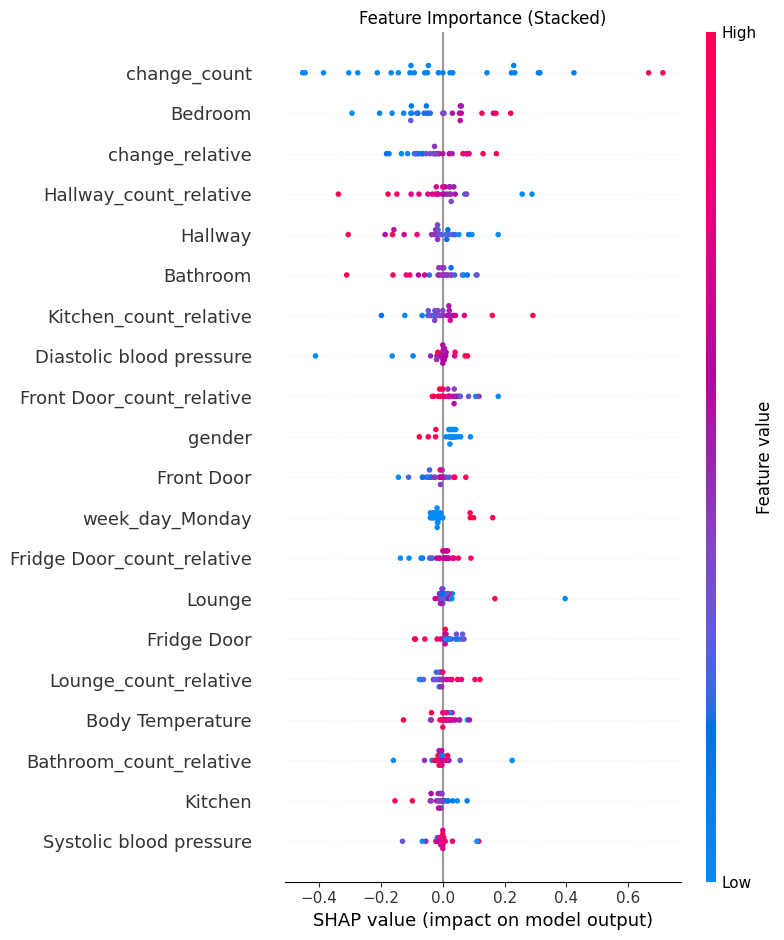

    feature  importance  cumulative_importance
0         9    0.228470               0.182251
1        14    0.097152               0.259748
2        10    0.072799               0.317820
3        26    0.071066               0.374509
4        18    0.065522               0.426776
5        16    0.055948               0.471405
6        20    0.052494               0.513280
7        29    0.039441               0.544742
8        21    0.038670               0.575589
9         8    0.034821               0.603365
10       13    0.034748               0.631083
11        1    0.034042               0.658239
12       19    0.033017               0.684577
13       17    0.031472               0.709682
14       11    0.030422               0.733950
15       25    0.030318               0.758134
16       27    0.028423               0.780807
17       24    0.027811               0.802992
18       12    0.026082               0.823797
19       28    0.024396               0.843258
20       30  

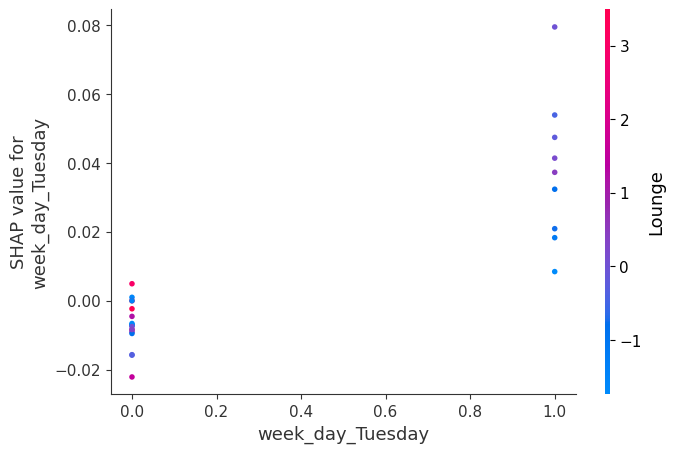

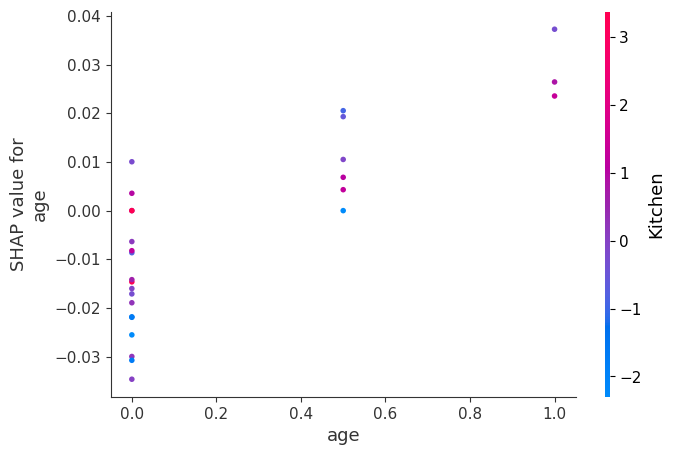

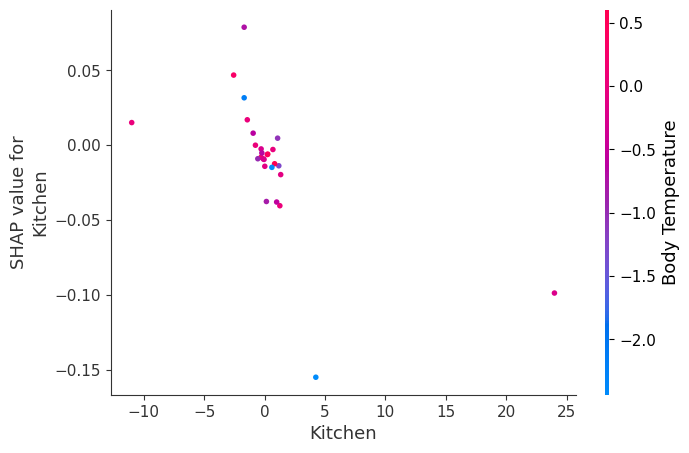

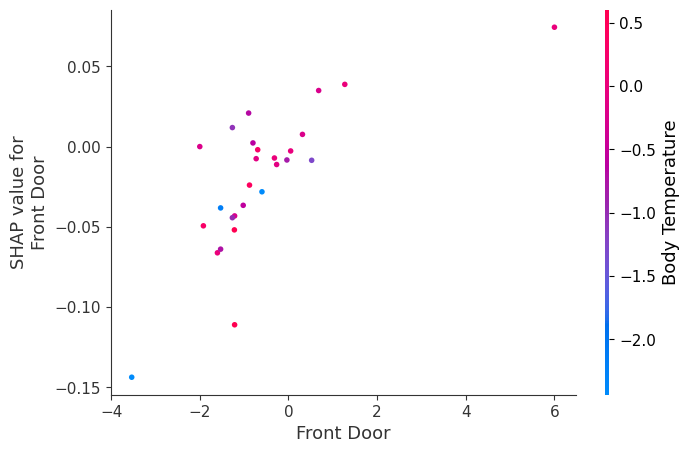

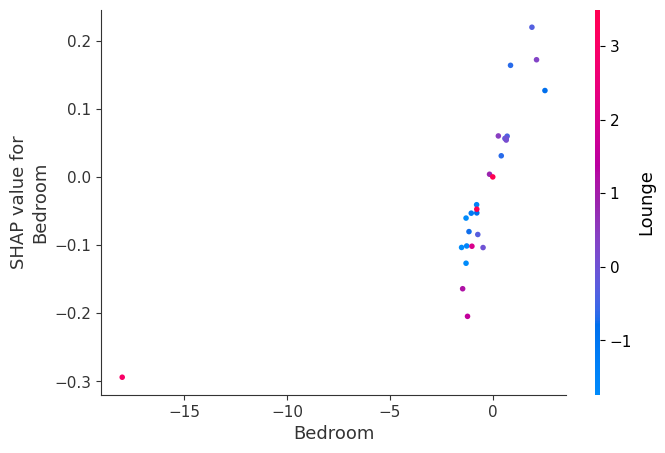

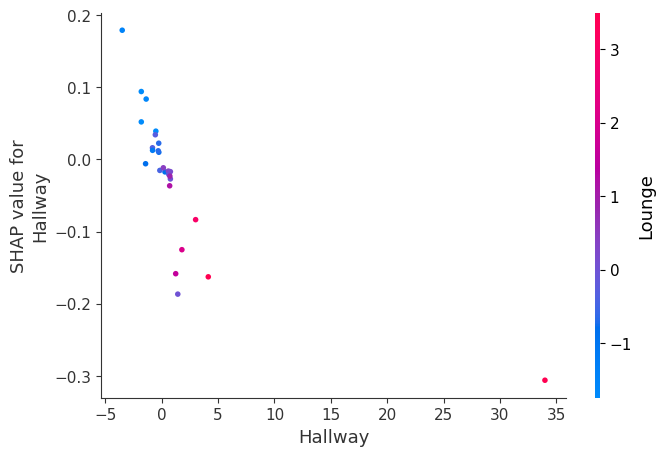

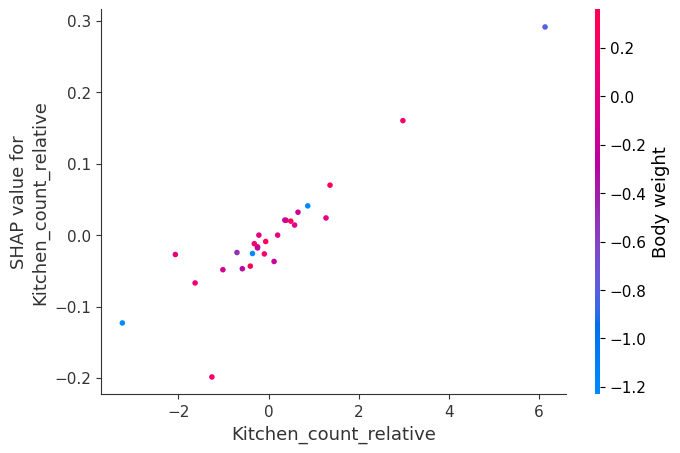

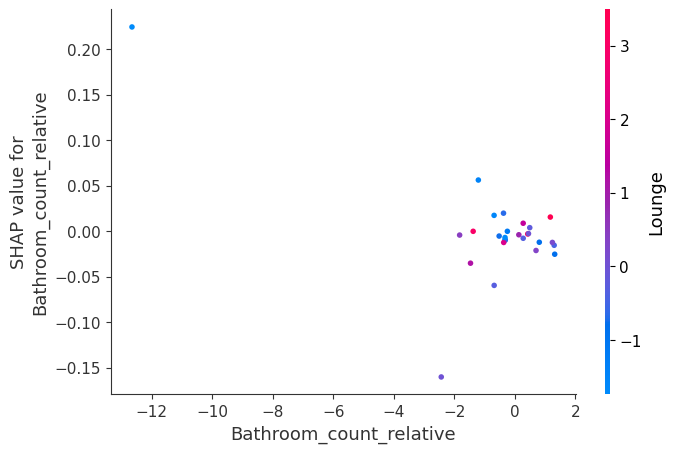

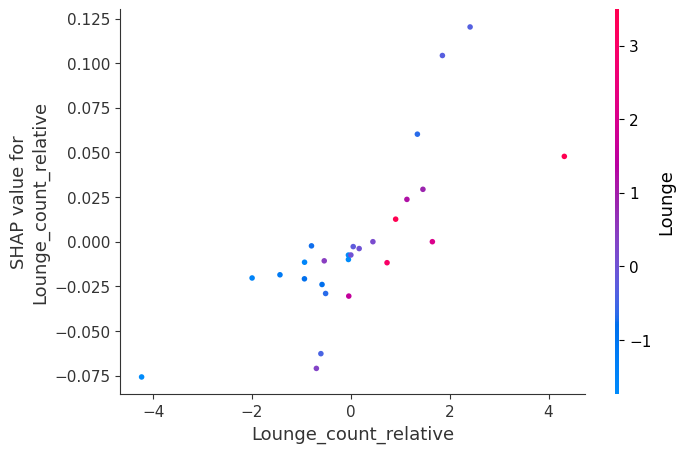

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
import shap

# Generate synthetic dataset
np.random.seed(42)

# Define and train the MLP model
model = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred)

# Calculate specificity
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, y_pred)

# Calculate PR AUC
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall_curve, precision_curve)

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Sensitivity (Recall): {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"PR AUC: {pr_auc:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

# Detailed classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Compute SHAP values
explainer = shap.KernelExplainer(model.predict, X_train)
shap_values = explainer.shap_values(X_test)

# Create a single figure for visualizing feature importance
plt.figure(figsize=(10, 6))

# Plot summary of feature importance
shap.summary_plot(shap_values, X_test, plot_type="dot", show=False)
plt.title('Feature Importance (Stacked)')

plt.tight_layout()
plt.show()

# Calculate cumulative importance of features
shap_values_mean = np.mean(np.abs(shap_values), axis=0)  # mean absolute SHAP values
feature_importance = pd.DataFrame({'feature': range(X_train.shape[1]), 'importance': shap_values_mean})
feature_importance = feature_importance.sort_values(by='importance', ascending=False).reset_index(drop=True)

# Calculate cumulative importance
feature_importance['cumulative_importance'] = feature_importance['importance'].cumsum() / feature_importance['importance'].sum()

# Display feature importance and cumulative importance
print(feature_importance)

# Identify negative impact features
negative_impact_features = [i for i in range(X_train.shape[1]) if (shap_values[:, i] < 0).mean() > 0.5]
print("\nFeatures with negative impact:", negative_impact_features)

# Check correlation with target
correlation = pd.DataFrame(X_train).corrwith(pd.Series(y_train))
harmful_features = [feature for feature in negative_impact_features if correlation[feature] < 0]
print("\nHarmful features:", harmful_features)

# Create dependence plots for harmful features
for feature in harmful_features:
    shap.dependence_plot(feature, shap_values, X_test)


Accuracy: 0.59
F1 Score: 0.56
Precision: 0.58
Sensitivity (Recall): 0.54
Specificity: 0.64
PR AUC: 0.67
ROC AUC: 0.59

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.64      0.62        14
           1       0.58      0.54      0.56        13

    accuracy                           0.59        27
   macro avg       0.59      0.59      0.59        27
weighted avg       0.59      0.59      0.59        27



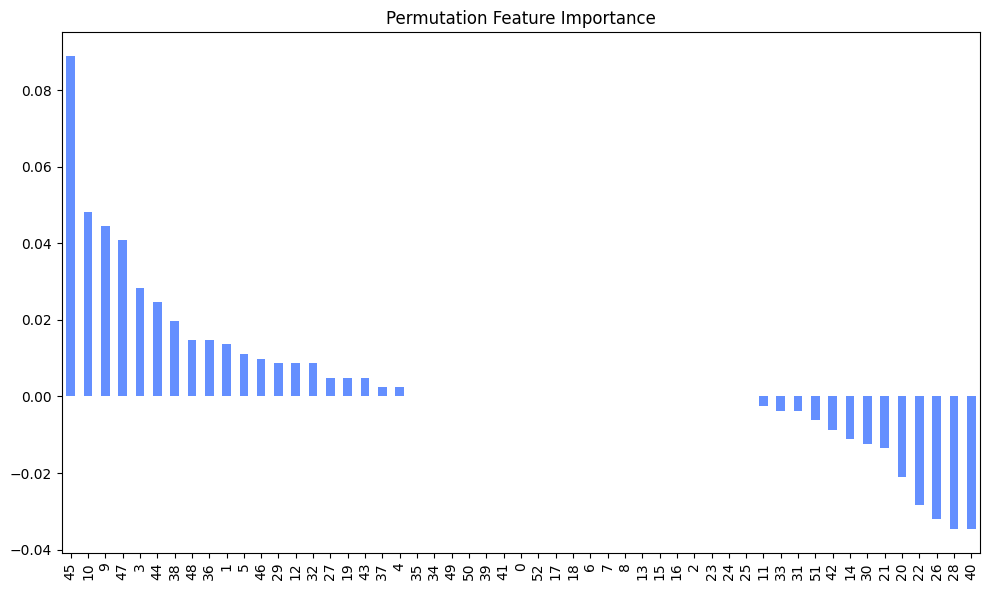

    feature    importance  cumulative_importance
0        45  8.888889e-02               0.461538
1        10  4.814815e-02               0.711538
2         9  4.444444e-02               0.942308
3        47  4.074074e-02               1.153846
4         3  2.839506e-02               1.301282
5        44  2.469136e-02               1.429487
6        38  1.975309e-02               1.532051
7        48  1.481481e-02               1.608974
8        36  1.481481e-02               1.685897
9         1  1.358025e-02               1.756410
10        5  1.111111e-02               1.814103
11       46  9.876543e-03               1.865385
12       29  8.641975e-03               1.910256
13       12  8.641975e-03               1.955128
14       32  8.641975e-03               2.000000
15       27  4.938272e-03               2.025641
16       19  4.938272e-03               2.051282
17       43  4.938272e-03               2.076923
18       37  2.469136e-03               2.089744
19        4  2.46913

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
from sklearn.inspection import permutation_importance

# Generate synthetic dataset
np.random.seed(42)

# Define and train the MLP model
model = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred)

# Calculate specificity
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, y_pred)

# Calculate PR AUC
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall_curve, precision_curve)

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Sensitivity (Recall): {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"PR AUC: {pr_auc:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

# Detailed classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Compute Permutation Feature Importance
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42)

# Create a single figure for visualizing feature importance
plt.figure(figsize=(10, 6))

# Plot summary of feature importance
feature_importance = pd.Series(perm_importance.importances_mean, index=range(X_train.shape[1]))
feature_importance.sort_values(ascending=False).plot(kind='bar')
plt.title('Permutation Feature Importance')

plt.tight_layout()
plt.show()

# Calculate cumulative importance of features
feature_importance = pd.DataFrame({'feature': range(X_train.shape[1]), 'importance': perm_importance.importances_mean})
feature_importance = feature_importance.sort_values(by='importance', ascending=False).reset_index(drop=True)

# Calculate cumulative importance
feature_importance['cumulative_importance'] = feature_importance['importance'].cumsum() / feature_importance['importance'].sum()

# Display feature importance and cumulative importance
print(feature_importance)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
import lime
import lime.lime_tabular

seed = 42
np.random.seed(seed)


X_train, y_train = X_train.to_numpy(), y_train.to_numpy()
X_val, y_val = X_val.to_numpy(), y_val.to_numpy()
X_test, y_test = X_test.to_numpy(), y_test.to_numpy()

# Define and train the MLP model
model = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300, random_state=seed)
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred)

# Calculate specificity
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, y_pred)

# Calculate PR AUC
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall_curve, precision_curve)

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Sensitivity (Recall): {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"PR AUC: {pr_auc:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

# Detailed classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, mode='classification', feature_names=[f'Feature {i}' for i in range(X_train.shape[1])], class_names=['Class 0', 'Class 1'], discretize_continuous=True)

# Explain a single instance
i = 0  # Index of the instance you want to explain
exp = explainer.explain_instance(X_test[i], model.predict_proba, num_features=n_features)

# Show the explanation
exp.show_in_notebook(show_table=True, show_all=False)


Accuracy: 0.59
F1 Score: 0.56
Precision: 0.58
Sensitivity (Recall): 0.54
Specificity: 0.64
PR AUC: 0.67
ROC AUC: 0.59

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.64      0.62        14
           1       0.58      0.54      0.56        13

    accuracy                           0.59        27
   macro avg       0.59      0.59      0.59        27
weighted avg       0.59      0.59      0.59        27



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

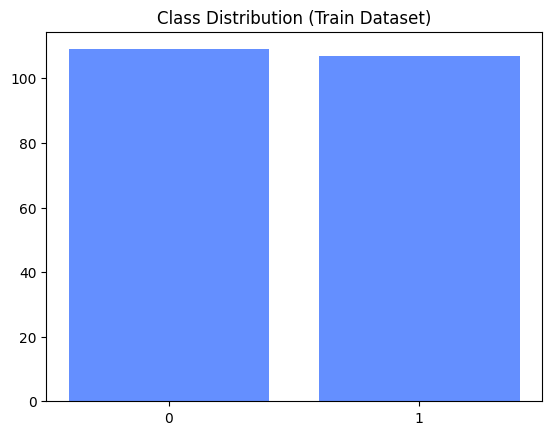

In [ ]:
count_one = np.sum(y_train)
count_zero = len(y_train) - count_one
plt.bar(['0', '1'], [count_zero, count_one])
plt.title('Class Distribution (Train Dataset)')
plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

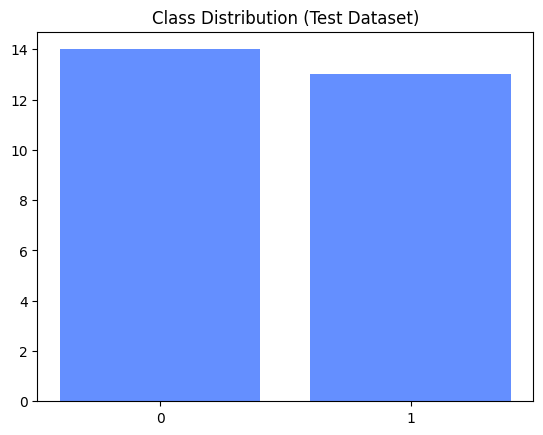

In [ ]:
count_one = np.sum(y_test)
count_zero = len(y_test) - count_one
plt.bar(['0', '1'], [count_zero, count_one])
plt.title('Class Distribution (Test Dataset)')
plt